# Part 2: Data wrangling

In [42]:
# load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## data sources

Google data:
https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps?resource=download
https://www.kaggle.com/datasets/lava18/google-play-store-apps

In [2]:
#import and cleaning data
google = "data/googleplaystore.csv"
df = pd.read_csv(google)
df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


In [3]:
# rename column names for tidiness
old_columns = pd.DataFrame(list(df.columns),columns = ["old"])
old_columns['new']= old_columns.old.str.replace('[^\w\s]','',regex = True).str.replace(' ','_').str.lower()
df.rename(columns = dict(zip(old_columns.old,old_columns.new)), 
          inplace =True)
df.head(1)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app             10841 non-null  object 
 1   category        10841 non-null  object 
 2   rating          9367 non-null   float64
 3   reviews         10841 non-null  object 
 4   size            10841 non-null  object 
 5   installs        10841 non-null  object 
 6   type            10840 non-null  object 
 7   price           10841 non-null  object 
 8   content_rating  10840 non-null  object 
 9   genres          10841 non-null  object 
 10  last_updated    10841 non-null  object 
 11  current_ver     10833 non-null  object 
 12  android_ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


### Checking data types
Observing the data types of each column with reference to the first few rows:
- 'reviews' should be an integer instead of object
- 'size' should be an integer or float instead of object
- 'price' should be integer or float instead of object
- 'type' should be categorical instead of object
- 'last_updated' should be a date instead of object

#### Cleaning 'reviews'

In [5]:
# Filtering all rows where review is not a number
df.loc[df.reviews.str.isnumeric()==False]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [6]:
# upon closer inspection, row's data does not make sense
print("Size before dropping: ", df.shape)
df.drop(df.loc[df.reviews.str.isnumeric()==False].index, inplace = True)
df.reset_index(drop = True, inplace = True);
print("Size after dropping: ", df.shape)

# convert df reviews to integer type
df.reviews = df.reviews.astype('int64')

Size before dropping:  (10841, 13)
Size after dropping:  (10840, 13)


#### Cleaning 'size'

In [7]:
df['size_bytes'] = np.NaN
df['size_unit'] = df['size'].str.lower().str[-1]
df['numbers']= df['size'].str.extract('(\d+)')

In [8]:
df['size_unit'].groupby(df['size_unit']).value_counts().sort_values(ascending=False)

size_unit  size_unit
m          m            8829
e          e            1695
k          k             316
Name: size_unit, dtype: int64

In [9]:
df['size'].groupby(df['size']).value_counts().sort_values(ascending=False)

size                size              
Varies with device  Varies with device    1695
11M                 11M                    198
12M                 12M                    196
14M                 14M                    194
13M                 13M                    191
                                          ... 
642k                642k                     1
643k                643k                     1
647k                647k                     1
269k                269k                     1
516k                516k                     1
Name: size, Length: 461, dtype: int64

Size is recorded as an abbreviation of unit plus measurement.  
The units should be removed and all size converted to bytes.  
Any entries with "Varies with device" will be converted to Null.

In [10]:
for row in range(len(df)):
    if df.loc[row,'size_unit'] == 'k':
        df.loc[row,'size_bytes'] = float(df.loc[row,'numbers'])*1000
    elif df.loc[row,'size_unit'] == 'm':
        df.loc[row,'size_bytes'] = float(df.loc[row,'numbers'])*1000000
    else: df.loc[row,'size_bytes'] = np.NaN

In [11]:
df.drop(['size_unit','numbers', 'size'], inplace = True, axis = 1)
df.size_bytes = df.size_bytes.astype(float)

#### Cleaning 'Price'

In [12]:
df.price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [13]:
df.price = df.price.str.replace('$', '',regex =False)
df.price = df.price.astype(float)

#### Cleaning 'Type'

In [14]:
df.type.value_counts(dropna = False)

Free    10039
Paid      800
NaN         1
Name: type, dtype: int64

In [15]:
df.loc[~df.type.isin(['Free','Paid'])]

,app,category,rating,reviews,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,size_bytes
9148,Command & Conquer: Rivals,FAMILY,NaN,0,0,NaN,0.0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device,NaN


In [16]:
print("Size before dropping: ", df.shape)
df.drop(df.loc[~df.type.isin(['Free','Paid'])].index,inplace=True)
df.reset_index(inplace=True, drop = True)
print("Size after dropping: ", df.shape)

df['type'] = df['type'].astype('category')

Size before dropping:  (10840, 13)
Size after dropping:  (10839, 13)


#### Cleaning 'last_updated'

In [17]:
df['last_updated'] = pd.to_datetime(df['last_updated'])

#### Reviewing cleaned Google data

In [18]:
google_df = df
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10839 entries, 0 to 10838
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app             10839 non-null  object        
 1   category        10839 non-null  object        
 2   rating          9366 non-null   float64       
 3   reviews         10839 non-null  int64         
 4   installs        10839 non-null  object        
 5   type            10839 non-null  category      
 6   price           10839 non-null  float64       
 7   content_rating  10839 non-null  object        
 8   genres          10839 non-null  object        
 9   last_updated    10839 non-null  datetime64[ns]
 10  current_ver     10831 non-null  object        
 11  android_ver     10837 non-null  object        
 12  size_bytes      9145 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 1.0+ MB


In [19]:
google_df = google_df[['app','category','rating','reviews','price','size_bytes']]

In [20]:
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10839 entries, 0 to 10838
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         10839 non-null  object 
 1   category    10839 non-null  object 
 2   rating      9366 non-null   float64
 3   reviews     10839 non-null  int64  
 4   price       10839 non-null  float64
 5   size_bytes  9145 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 508.2+ KB


## Cleaning Apple Data

In [21]:
apple = "data/AppleStore.csv"
df = pd.read_csv(apple)
df.head(2)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1


In [22]:
df.currency.unique()

array(['USD'], dtype=object)

In [23]:
df = df[['track_name','prime_genre', 'user_rating', 'rating_count_tot', 'price', 'size_bytes']]

In [24]:
df.rename(columns = dict(zip(df.columns,list(google_df.columns))), inplace = True)

In [25]:
df.head()

,app,category,rating,reviews,price,size_bytes
0,PAC-MAN Premium,Games,4.0,21292,3.99,100788224
1,Evernote - stay organized,Productivity,4.0,161065,0.00,158578688
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",Weather,3.5,188583,0.00,100524032
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",Shopping,4.0,262241,0.00,128512000
4,Bible,Reference,4.5,985920,0.00,92774400


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         7197 non-null   object 
 1   category    7197 non-null   object 
 2   rating      7197 non-null   float64
 3   reviews     7197 non-null   int64  
 4   price       7197 non-null   float64
 5   size_bytes  7197 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 337.5+ KB


In [27]:
df.size_bytes = df.size_bytes.astype(float)

In [28]:
apple_df = df

## Combining Google and Apple app data

In [29]:
google_df['store'] = "google"
apple_df['store'] = "apple"
print("Google data size before append: ", google_df.shape)
print("Apple data size before append: ", apple_df.shape)
app_df = pd.concat([google_df, apple_df])
print("Size after append: ", app_df.shape)

Google data size before append:  (10839, 7)
Apple data size before append:  (7197, 7)
Size after append:  (18036, 7)


# Part 3 Exploratory Data Analysis

In [30]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18036 entries, 0 to 7196
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         18036 non-null  object 
 1   category    18036 non-null  object 
 2   rating      16563 non-null  float64
 3   reviews     18036 non-null  int64  
 4   price       18036 non-null  float64
 5   size_bytes  16342 non-null  float64
 6   store       18036 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


In [31]:
temp = app_df[app_df.rating.isnull()==True]
temp.groupby(by = 'store').store.value_counts()

store   store 
google  google    1473
Name: store, dtype: int64

In [32]:
temp.sort_values(by = "reviews", ascending = False).head()

,app,category,rating,reviews,price,size_bytes,store
3589,We learn children's verses in kindergarten,PARENTING,NaN,3248,0.0,6000000.0,google
9566,Adivina el Emoji,GAME,NaN,2536,0.0,32000000.0,google
1559,Young Speeches,LIBRARIES_AND_DEMO,NaN,2221,0.0,2000000.0,google
321,【Ranobbe complete free】 Novelba - Free app tha...,COMICS,NaN,1330,0.0,22000000.0,google
9611,Em Fuga Brasil,FAMILY,NaN,1317,0.0,60000000.0,google


In [33]:
# Remove all rows where rating is null since our target variable is null
print("Before dropping null ratings",app_df.shape)
app_df = app_df[app_df.rating.isnull()==False]
print("After dropping null ratings",app_df.shape)

Before dropping null ratings (18036, 7)
After dropping null ratings (16563, 7)


In [34]:
# Also remove all rows where reviews = 0
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16563 entries, 0 to 7196
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app         16563 non-null  object 
 1   category    16563 non-null  object 
 2   rating      16563 non-null  float64
 3   reviews     16563 non-null  int64  
 4   price       16563 non-null  float64
 5   size_bytes  14926 non-null  float64
 6   store       16563 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.0+ MB


In [35]:
print("Before dropping apps with 0 reviews",app_df.shape)
app_df = app_df[app_df.reviews != 0]
print("After dropping apps with 0 reviews",app_df.shape)

Before dropping apps with 0 reviews (16563, 7)
After dropping apps with 0 reviews (15634, 7)


In [36]:
app_df.reset_index(inplace = True)

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

The Google store has a mean app rating of 4.192, 0.142 higher than Apple store's mean app rating of 4.050. 

A permutation test was performed to verify if the observed difference of means between the Apple and Google store is significant.   

In [38]:
app_df.groupby(by = "store").rating.describe().T

store,apple,google
count,6268.000000,9366.000000
mean,4.049697,4.191757
std,0.726943,0.515219
min,1.000000,1.000000
25%,4.000000,4.000000
50%,4.500000,4.300000
75%,4.500000,4.500000
max,5.000000,5.000000


To appropriately select a suitable test statistic, the distributions of app ratings between Apple and Google were examined using histograms and boxplots.

It was observed that app ratings are not normally distributed, meaning that a non-parametric test should be used.

Further numerical testing also verified that the distributions are not normal.

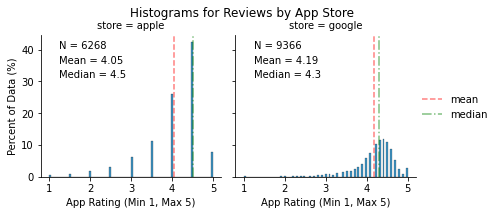

In [39]:
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.set_style()
sns.set_palette('colorblind')

g = sns.FacetGrid(app_df[['rating','store']], col = 'store', col_order = list(app_df.store.sort_values().unique()))

def mean_median_line(data, **kws):
    mean = data.rating.mean()
    median = data.rating.median()
    ax = plt.gca()
    ax.axvline(x = mean, c = 'r', linestyle = '--', alpha = 0.5, label = "mean")
    ax.axvline(x = median, c = 'g', linestyle = '-.', alpha = 0.5, label = "median")
    
    n =len(data)    
    ax.text(0.1, 0.9, f"N = {n}", transform = ax.transAxes)
    ax.text(0.1, 0.8, f"Mean = {round(mean,2)}", transform = ax.transAxes)
    ax.text(0.1, 0.7, f"Median = {round(median,2)}", transform = ax.transAxes)
    
g.map_dataframe(sns.histplot,'rating', stat = "percent")
g.map_dataframe(mean_median_line)
g.add_legend()
g.set_axis_labels("App Rating (Min 1, Max 5)","Percent of Data (%)")
g.fig.subplots_adjust(top = 0.85)
g.fig.suptitle('Histograms for Reviews by App Store')
plt.show

#fig = g.get_figure()
plt.savefig('Histograms for Ratings by App Store.png',
            dpi = 300, 
            format = 'png')

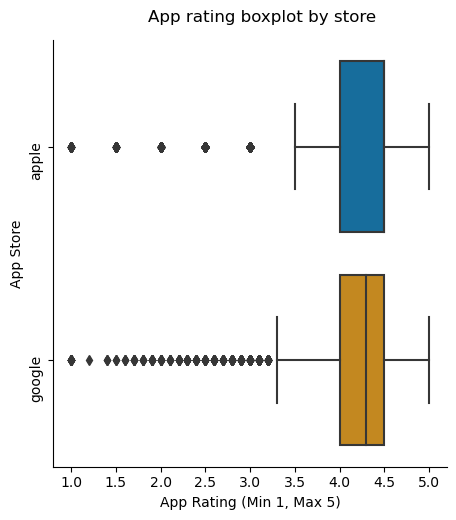

In [41]:
sns.set_style()
sns.set_palette("colorblind")
_ = sns.catplot(data = app_df,
                x = 'rating',
                kind = 'box',
                y = 'store',
                order = list(app_df.store.sort_values().unique())
               )
_.fig.suptitle("App rating boxplot by store",
                x= 0.6, y= 1.03)
_.set(xlabel = "App Rating (Min 1, Max 5)",
      ylabel = "App Store")
plt.yticks(rotation = 90)
plt.show()

In [45]:
apple_normal = stats.normaltest(app_df['rating'][app_df.store == 'apple'])
google_normal = stats.normaltest(app_df['rating'][app_df.store == 'google'])
print('The D’Agostino and Pearson’s normality test yielded results:')
print('Apple: ', apple_normal)
print('Google: ', google_normal)
print('The p-value of 0 from both tests confirms the visual observation that app ratings are not normally distributed')


The D’Agostino and Pearson’s normality test yielded results:
Apple:  NormaltestResult(statistic=1778.9974234584017, pvalue=0.0)
Google:  NormaltestResult(statistic=3678.6157187516856, pvalue=0.0)
The p-value of 0 from both tests confirms the visual observation that app ratings are not normally distributed


# Permutation Testing

### Null hypothesis:

**H<sub>null</sub>**: the observed difference in the mean app rating between Apple and Google store is due to chance and is not significant.

**H<sub>alternative</sub>**: the observed difference in the mean app rating between Apple and Google store is **not** due to chance and **is** significant.

### Methodology:
1. Assume that the app stores of Google and Apple have no impact on rating.
2. While keeping the store constant, the rating column was shuffled. Based on aforementioned assumption, the null hypothesis is not proven false if the replicate of the test statistic, the difference of app rating means between stores, is similar to the observed difference of 0.142.
3. 10000 replicate samples and replicates were taken.

In [50]:
def diff_of_mean(data1, data2, func = np.mean):
    """ Test statistic for difference of means"""
    return func(data2)-func(data1)

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size =1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [51]:
apple = app_df.rating[app_df.store == 'apple']
google = app_df.rating[app_df.store == 'google']

permutation_replicates = draw_perm_reps(apple, google, diff_of_mean,10000)

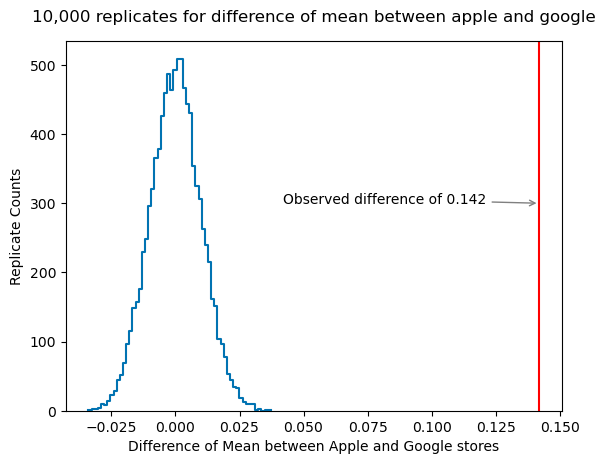

In [79]:
sns.set_style()
sns.set_palette('colorblind')

_ = sns.histplot(data = permutation_replicates,
                element = 'step',
                fill = False)

_ = plt.axvline(diff_of_mean(apple,google), color='r')
plt.title("10,000 replicates for difference of mean between apple and google", y =1.03)
plt.xlabel("Difference of Mean between Apple and Google stores")
plt.ylabel("Replicate Counts")

plt.annotate("Observed difference of 0.142", xy = (diff_of_mean(apple,google),300), 
xytext = (diff_of_mean(apple,google)-0.10,300), 
arrowprops = {"arrowstyle":"->", "color":"gray"})

plt.show()


In [66]:
p_value = np.sum(permutation_replicates[permutation_replicates > diff_of_mean(apple, google)])/len(permutation_replicates)
print('p-value for hypothesis test: ',p_value)

p-value for hypothesis test:  0.0


# Conclusion:

Based on 10,000 replicates generated from the permutation test, a p-value of 0 allows the rejection of the null hypothesis.

The observed difference of 0.142 in the mean of app ratings between the Apple and Google store is significant.

Thus, it is recommended that the client focus on integrating Google Play first.